In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers
from keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data
with open("imdb_labelled.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# print sample of raw data
lines[0:5] # list of individual reviews with sentiment label

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  \t0\n',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  \t0\n',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  \t0\n',
 'Very little music or anything to speak of.  \t0\n',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  \t1\n']

In [3]:
# clean / pre-process data

# many examples of numbers represent positive or negative review
def replace_num_with_text(line):
    new_line = ""
    nums = {"0": "zero",
            "1": "one",
            "2": "two",
            "3": "three",
            "4": "four",
            "5": "five",
            "6": "six",
            "7": "seven",
            "8": "eight",
            "9": "nine",
            "10": "ten",
            }
    for i, char in enumerate(line):
        if char in nums.keys():
            if char == "1" and line[i+1] == "0":
                new_line = new_line + nums["10"]
            else:
                new_line = new_line + nums[char]
        else:
            new_line = new_line + char
    return new_line

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df = pd.DataFrame(columns=["original", "review", "label", "word_length"])

new_lines = []
labels = []

for line in lines:
    # remove leading and trailing whitespace
    new_line = line.strip()
    # convert all text to lowercase
    new_line = new_line.lower()
    # remove punctuation
    punct_remover = str.maketrans(' ', ' ', string.punctuation)
    new_line = new_line.translate(punct_remover)
    # extract label from end
    label = int(new_line[-1])
    new_line = new_line[:-3] # remove label
    labels.append(label)
    # replace 1-10 numbers to text
    new_line = replace_num_with_text(new_line)
    # remove numbers and other non-word characters
    new_line = re.sub(r'\d+', ' ', new_line)
    # remove escape sequences
    new_line = new_line.replace("\n", " ").replace("\t", " ")
    # remove stop words
    tokens = word_tokenize(new_line, language='english', preserve_line=True)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # lemmatization
    for i, word in enumerate(filtered_tokens):
        new_word = lemmatizer.lemmatize(word, pos='v')
        filtered_tokens[i] = new_word
    new_lines.append(filtered_tokens)  # append to new_lines list

df["original"] = lines
df["review"] = new_lines
df["label"] = labels

df['word_length'] = df['review'].apply(len)
df.sort_values(by="word_length")

,original,review,label,word_length
13,It Was So Cool. \t1\n,[cool],1,1
420,It just blew. \t0\n,[blow],0,1
406,I liked it. \t1\n,[like],1,1
92,It was horrendous. \t0\n,[horrendous],0,1
105,Very disappointing. \t0\n,[disappoint],0,1
...,...,...,...,...
428,The use of slow-motion needlessly repeats itse...,"[use, slowmotion, needlessly, repeat, througho...",0,29
469,A cheap and cheerless heist movie with poor ch...,"[cheap, cheerless, heist, movie, poor, charact...",0,31
421,This movie is excellent!Angel is beautiful and...,"[movie, excellentangel, beautiful, scamp, ador...",1,35
390,Though The Wind and the Lion is told largely t...,"[though, wind, lion, tell, largely, eye, son, ...",1,37


In [4]:
pd.set_option('display.max_colwidth', None)
reviews =df["review"]
print(reviews)

0                                                                                              [slowmoving, aimless, movie, distress, drift, young, man]
1                                                                                            [sure, lose, flat, character, audience, nearly, half, walk]
2      [attempt, artiness, black, white, clever, camera, angle, movie, disappoint, become, even, ridiculous, act, poor, plot, line, almost, nonexistent]
3                                                                                                                       [little, music, anything, speak]
4                                                                                        [best, scene, movie, gerardo, try, find, song, keep, run, head]
                                                                             ...                                                                        
995                                                                               

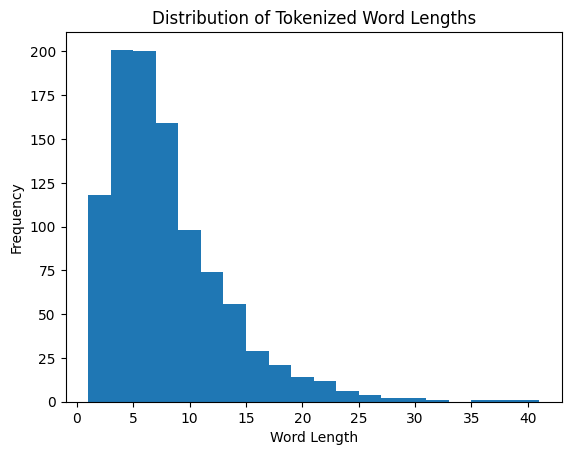

Min: 1
Mean: 7.55
Median: 6.0
90th percentile: 14.0
95th percentile: 18.0
Max: 41


In [5]:
# visualize stats around tokenized sequence lengths

plt.hist(df["word_length"], bins=20)
plt.title("Distribution of Tokenized Word Lengths")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

# summary statistics of sequence lengths

print(f"Min: {np.min(df['word_length'])}")
print(f"Mean: {np.mean(df['word_length']):.2f}")
print(f"Median: {np.median(df['word_length'])}")
print(f"90th percentile: {np.percentile(df['word_length'], 90)}")
print(f"95th percentile: {np.percentile(df['word_length'], 95)}")
print(f"Max: {np.max(df['word_length'])}")

In [6]:
# create tokenizer and padded_sequence
words = df.review.values
tokenizer = Tokenizer(num_words=1500, oov_token='<OOV>')
tokenizer.fit_on_texts(words)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(words)
padded_sequence = pad_sequences(encoded_docs, maxlen=20)

word_index = tokenizer.word_index
print(word_index)

word_counts = tokenizer.word_counts
print(word_counts)

{'<OOV>': 1, 'film': 2, 'movie': 3, 'one': 4, 'bad': 5, 'see': 6, 'make': 7, 'like': 8, 'character': 9, 'good': 10, 'time': 11, 'watch': 12, 'act': 13, 'really': 14, 'great': 15, 'even': 16, 'think': 17, 'love': 18, 'well': 19, 'get': 20, 'movies': 21, 'look': 22, 'ever': 23, 'play': 24, 'story': 25, 'plot': 26, 'go': 27, 'script': 28, 'work': 29, 'give': 30, 'dont': 31, 'best': 32, 'cast': 33, 'also': 34, 'write': 35, 'way': 36, 'end': 37, 'waste': 38, 'show': 39, 'would': 40, 'didnt': 41, 'real': 42, 'could': 43, 'every': 44, 'much': 45, 'line': 46, 'find': 47, 'say': 48, 'scenes': 49, 'recommend': 50, 'know': 51, 'funny': 52, 'better': 53, 'actors': 54, 'wonderful': 55, 'little': 56, 'two': 57, 'interest': 58, 'tenzero': 59, 'never': 60, 'use': 61, 'everything': 62, 'bore': 63, 'come': 64, 'anyone': 65, 'part': 66, 'excellent': 67, 'totally': 68, 'suck': 69, 'scene': 70, 'enjoy': 71, 'people': 72, 'years': 73, 'nothing': 74, 'stupid': 75, 'awful': 76, 'still': 77, 'many': 78, 'man':

In [7]:
print(padded_sequence[0:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0  995
   996    3  997  611  309   79]
 [   0    0    0    0    0    0    0    0    0    0    0    0  423  200
   612    9  244  998  201  424]
 [   0    0  141  999  111  125  245  142  425    3  143  165   16  246
    13  202   26   46  126 1000]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   56   80  166  310]
 [   0    0    0    0    0    0    0    0    0    0   32   70    3 1001
   127   47  311  167  312  426]]


In [8]:
df.head(5)

,original,review,label,word_length
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man. \t0\n","[slowmoving, aimless, movie, distress, drift, young, man]",0,7
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out. \t0\n","[sure, lose, flat, character, audience, nearly, half, walk]",0,8
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent. \t0\n","[attempt, artiness, black, white, clever, camera, angle, movie, disappoint, become, even, ridiculous, act, poor, plot, line, almost, nonexistent]",0,18
3,Very little music or anything to speak of. \t0\n,"[little, music, anything, speak]",0,4
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head. \t1\n,"[best, scene, movie, gerardo, try, find, song, keep, run, head]",1,10


In [9]:
# split dataset into training(80%), validating(10%), and testing(10%) datasets

X = padded_sequence
y = df["label"]

# 80% training
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=19)
# split temp into 50% validating and 50% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=19)

In [10]:
print(f"Length of Training Set: {len(X_train)}")
print(f"Length of Validating Set: {len(X_val)}")
print(f"Length of Testing Set: {len(X_test)}")

Length of Training Set: 800
Length of Validating Set: 100
Length of Testing Set: 100


In [11]:
# save datasets to csv

train_zip = list(zip(X_train, y_train))
train = pd.DataFrame(train_zip, columns=["embeddings", "labels"])
train.to_csv('training_final.csv', index=False)

val_zip = list(zip(X_val, y_val))
val = pd.DataFrame(val_zip, columns=["embeddings", "labels"])
val.to_csv('validating_final.csv', index=False)

test_zip = list(zip(X_test, y_test))
test = pd.DataFrame(test_zip, columns=["embeddings", "labels"])
test.to_csv('testing_final.csv', index=False)

print("Datasets saved to CSV")

Datasets saved to CSV


In [12]:
# create LSTM model

embedding_vector_length = 16
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(16, dropout=0.3, recurrent_dropout=0.5)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.build(input_shape=(None, 20))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 16)         │        43,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 20, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 18, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,185 (199.94 KB)

 Trainable params: 51,185 (199.94 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# set early stopping criteria
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath="checkpoint.model.keras", save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True, verbose=1)
callbacks = [early_stopping_callback, model_checkpoint_callback]

In [14]:
# fit the model on training data

history = model.fit(X_train, y_train, validation_split=0.0, validation_data=(X_val, y_val), callbacks=callbacks, epochs=75, batch_size=16)


Epoch 1/75
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5060 - loss: 0.7139
Epoch 1: val_loss improved from inf to 0.71281, saving model to checkpoint.model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5062 - loss: 0.7139 - val_accuracy: 0.5000 - val_loss: 0.7128
Epoch 2/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4848 - loss: 0.7132
Epoch 2: val_loss improved from 0.71281 to 0.71221, saving model to checkpoint.model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4850 - loss: 0.7132 - val_accuracy: 0.5400 - val_loss: 0.7122
Epoch 3/75
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5092 - loss: 0.7111
Epoch 3: val_loss improved from 0.71221 to 0.71161, saving model to checkpoint.model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5087 - loss: 0.7112 - val_accuracy: 0.5400 - val_loss: 0.7116
Epoch 4/75
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4716 - loss: 0.7122
Epoch 4: val_loss improved from 0.71161 to 

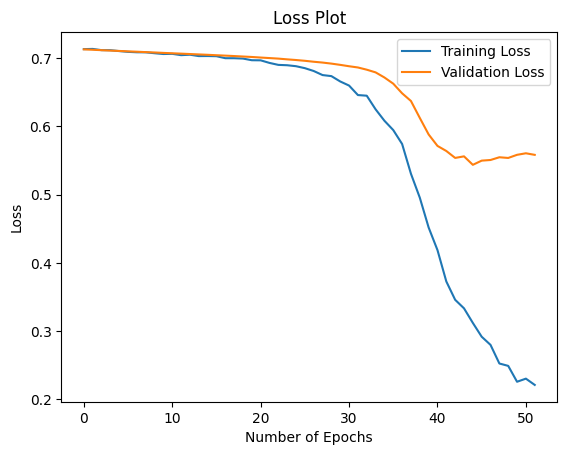

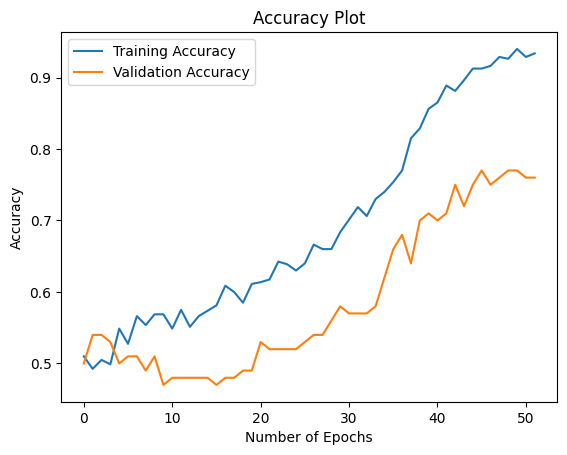

In [15]:
# plot training and validation loss by epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()

# plot training and validation accuracy by epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8457 - loss: 0.4327
Test Loss: 0.47418373823165894
Test Accuracy: 0.8199999928474426
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


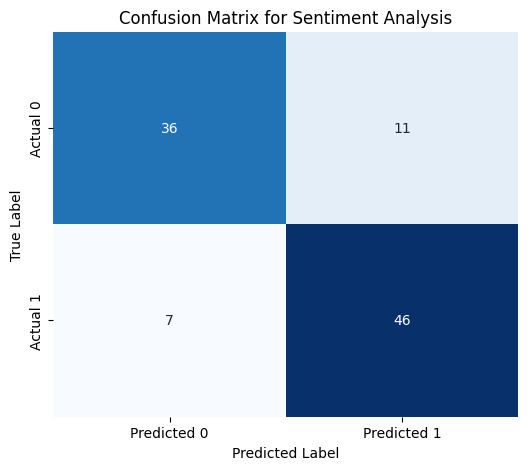

In [16]:
# load and test best model
model = tf.keras.models.load_model('checkpoint.model.keras')

# evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# make sample predictions
y_pred_probs = model.predict(X_test)
y_pred_probs = y_pred_probs.flatten()
y_pred_binary = (y_pred_probs > 0.5).astype(int)
y_pred_binary = y_pred_binary.flatten()

# visualize confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

In [17]:
# evaluate wrong predictions for insight
wrong_predictions_mask = (y_pred_binary != y_test)
wrong_predictions = np.where(wrong_predictions_mask)
mistakes = X_test[wrong_predictions]

# use reverse_word_index to convert mistakes back to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def sequences_to_texts(sequences, reverse_word_index):
    decoded_texts = []
    for seq in sequences:
        decoded_words = []
        for index in seq:
            if index != 0: # padding
                decoded_words.append(reverse_word_index.get(index, "<unk>")) # Use .get for robustness
        decoded_texts.append(" ".join(decoded_words))
    return decoded_texts

decoded_mistakes = sequences_to_texts(mistakes, reverse_word_index)
print(f"Decoded Mistakes:")
display(decoded_mistakes)

Decoded Mistakes:


['nothing short <OOV> <OOV> film',
 'simply excuse something poorly do',
 'strong <OOV> take stand exceptional act mostly <OOV> cast <OOV> script doesnt insult audience take easy way come white racism',
 'well keep think bad',
 'dont afraid <OOV> worth little <OOV> <OOV> tenzerotenzero',
 '<OOV> <OOV> <OOV> <OOV> macbeth <OOV> time sometimes look like <OOV> girl <OOV> <OOV> blood evil',
 '<OOV> plot <OOV> <OOV> <OOV> scenes <OOV>',
 'film redeem feature',
 'scamp sing ive never feel <OOV> totally recommend <OOV> come special <OOV> june <OOV> cover scamp garbage angel underneath <OOV>',
 'place good film garbage',
 'think <OOV> <OOV> fat better <OOV> cheesy clichés throw <OOV> <OOV> ready poorly <OOV> <OOV> <OOV> <OOV> <OOV> john <OOV>',
 'fact <OOV> <OOV> like <OOV> release',
 'movie lack visual interest drama expression feel celebration patriotism underline narrative',
 'scene debate whether sack trumpeter falsely accuse murder pure horror really stupid',
 'scene strong <OOV>',
 '<OOV